# Benchmarks of MCS processing methods with personalized noise-functions

In [4]:
import numpy as np
from numpy import pi as pi
import pandas as pd
import scipy.signal as sg
from matplotlib import pyplot as plt
from mcsm_benchmarks.Benchmark import Benchmark
from mcsm_benchmarks.ResultsInterpreter import ResultsInterpreter
from utils import spectrogram_thresholding, get_stft


## Creating a a dummy dictionary of methods 
First let us define a dummy method for testing. Methods should receive a numpy array with shape  ```(N,)``` where `N` is the number of time samples of the signal. Additionally, they can receive any number of positional or keyword arguments to allow testing different combinations of input parameters. The shape of the output depends on the task (signal denoising or detection). So the recommended signature of a method should be the following:

 `output = a_method(noisy_signal, *args, **kwargs) `.

If one set `task='denoising'`, `output` shoud be a `(N,)` numpy array, i.e. the same shape as the input parameter `noisy_signal`, whereas if `task='detection'`, the output should be boolean (`0` or `False` for no signal, and `1` or `True` otherwise).

After this, we need to create a *dictionary of methods* to pass the `Benchmark` object at the moment of instantiation.

In [5]:
def method_1(noisy_signal, *args, **kwargs):
    # If additional input parameters are needed, they can be passed in a tuple using 
    # *args or **kwargs and then parsed.
    xr = spectrogram_thresholding(noisy_signal,1.0,fun='hard')
    return xr

def method_2(noisy_signal, *args, **kwargs):
    # If additional input parameters are needed, they can be passed in a tuple using 
    # *args or **kwargs and then parsed.
    xr = spectrogram_thresholding(noisy_signal,2.0,fun='soft') 
    return xr

# Create a dictionary of the methods to test.
my_methods = {
    'Method 1': method_1, 
    'Method 2': method_2,
    }

## Benchmarks with different kinds of noise

Now we are ready to instantiate a `Benchmark` object and run a benchmark using the proposed methods.

The `Benchmark` constructor receives a number of input parameters.
The parameter `complex_noise` can be `True` or `False` indicating if the simulations are to be done using white complex Gaussian noise or not.
However, if a function is passed instead of a `bool` variable, the function is called in order to obtain a different realization of noise.
The noise generator function must receive an `int` variable indicating the length of the time series to generate:
`noise = noise_generator_fun(N,) `.


### Real White Gaussian noise (default)

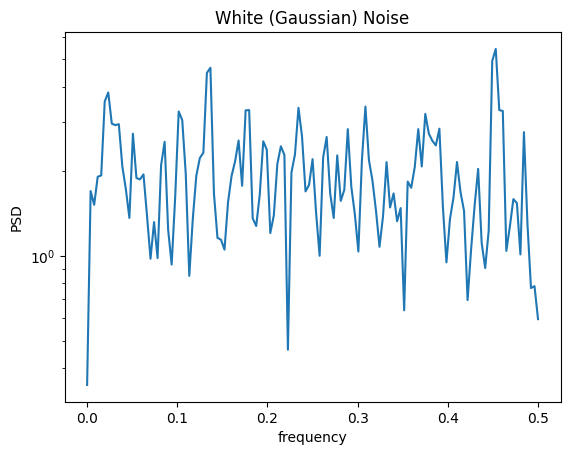

In [6]:
# Benchmark class uses np.random.randn(N,) to generate noise realizations
n = np.random.randn(1024)

f, Pxx_den = sg.welch(n)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency')
plt.ylabel('PSD')
plt.title('White (Gaussian) Noise')
plt.show()

In [7]:
benchmark = Benchmark(task = 'denoising', # defines the default performance function
                        methods = my_methods, # dictionary of methods
                        N = 256,  # Length of the signals
                        SNRin = [40, 50], # SNRs to use during the test
                        repetitions = 3, # Number of noise realizations to use
                        signal_ids=['LinearChirp', 'CosChirp',], # Signals to use
                        complex_noise=False # Real white Gaussian Noise
                        ) 
                        
benchmark.run_test() # Run the test.
results_df = benchmark.get_results_as_df() # This formats the results on a DataFrame
results_df

Running benchmark...
- Signal LinearChirp
- Signal CosChirp
The test has finished.


,Method,Parameter,Signal_id,Repetition,40,50
6,Method 1,"((), {})",CosChirp,0,43.971518,53.561819
7,Method 1,"((), {})",CosChirp,1,44.544033,54.096559
8,Method 1,"((), {})",CosChirp,2,43.790454,53.448276
0,Method 1,"((), {})",LinearChirp,0,44.068673,53.993409
1,Method 1,"((), {})",LinearChirp,1,44.457192,54.644148
2,Method 1,"((), {})",LinearChirp,2,43.631709,53.708958
9,Method 2,"((), {})",CosChirp,0,44.440979,53.041674
10,Method 2,"((), {})",CosChirp,1,45.302902,53.894885
11,Method 2,"((), {})",CosChirp,2,43.900369,52.533425
3,Method 2,"((), {})",LinearChirp,0,45.837933,54.778613


### Pink noise
Let's first import a function to generate colored noise, and later pass it as a parameter to the ```Benchmark``` class constructor.

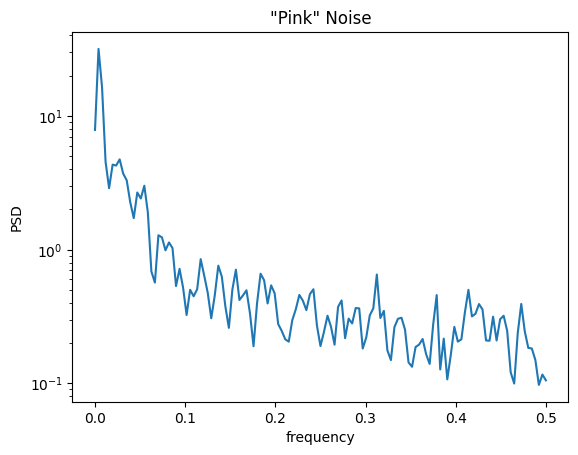

In [8]:
from utils import voss

#Generates pink noise using the Voss-McCartney algorithm.
noise_fun = lambda N : voss(N,)
n = noise_fun(1024)

f, Pxx_den = sg.welch(n)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency')
plt.ylabel('PSD')
plt.title('"Pink" Noise')
plt.show()

In [9]:
benchmark = Benchmark(task = 'denoising', # defines the default performance function
                        methods = my_methods, # dictionary of methods
                        N = 256,  # Length of the signals
                        SNRin = [40, 50], # SNRs to use during the test
                        repetitions = 3, # Number of noise realizations to use
                        signal_ids=['LinearChirp', 'CosChirp',], # Signals to use
                        complex_noise=noise_fun # "Pink" Noise
                        ) 
                        
benchmark.run_test() # Run the test.
results_df = benchmark.get_results_as_df() # This formats the results on a DataFrame
results_df

Running benchmark...
- Signal LinearChirp
- Signal CosChirp
The test has finished.


,Method,Parameter,Signal_id,Repetition,40,50
6,Method 1,"((), {})",CosChirp,0,42.020270,52.501531
7,Method 1,"((), {})",CosChirp,1,40.377870,51.031590
8,Method 1,"((), {})",CosChirp,2,41.166749,51.429858
0,Method 1,"((), {})",LinearChirp,0,41.639466,51.749439
1,Method 1,"((), {})",LinearChirp,1,40.305414,50.365133
2,Method 1,"((), {})",LinearChirp,2,41.417004,51.518874
9,Method 2,"((), {})",CosChirp,0,46.549252,56.121017
10,Method 2,"((), {})",CosChirp,1,44.205250,54.954600
11,Method 2,"((), {})",CosChirp,2,45.150989,54.085905
3,Method 2,"((), {})",LinearChirp,0,45.450849,55.530805
